# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

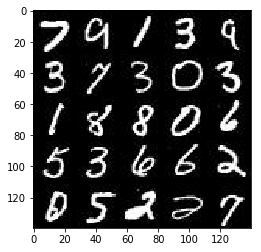

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

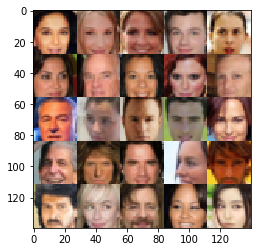

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    return (
        tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real'),
        tf.placeholder(tf.float32, (None, z_dim), name='input_z'),
        tf.placeholder(tf.float32, shape=None, name='learning_rate')
    )


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param alpha: Parametric leaky ReLU parameter
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
import numpy as np
def generator(z, out_channel_dim, is_train=True, alpha=0.2, reuse=None):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train if reuse is None else reuse
    with tf.variable_scope('generator', reuse=reuse):
        shape = (7, 7, 256)
        
        # First fully connected layer
        x1 = tf.layers.dense(z, np.product(shape))
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1,) + shape)
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        
        out = tf.tanh(logits)
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)

    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # NOTE: pretty much copied verbatim from the DCGAN-SVHN notebook
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate})

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[-1], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0768... Generator Loss: 6.1196
Epoch 1/2... Discriminator Loss: 3.5343... Generator Loss: 0.6363
Epoch 1/2... Discriminator Loss: 0.5480... Generator Loss: 1.2718
Epoch 1/2... Discriminator Loss: 2.2072... Generator Loss: 0.3572
Epoch 1/2... Discriminator Loss: 0.7686... Generator Loss: 1.2033
Epoch 1/2... Discriminator Loss: 1.2608... Generator Loss: 1.6191
Epoch 1/2... Discriminator Loss: 1.7172... Generator Loss: 0.3788
Epoch 1/2... Discriminator Loss: 1.5033... Generator Loss: 0.3886
Epoch 1/2... Discriminator Loss: 2.0830... Generator Loss: 2.9132
Epoch 1/2... Discriminator Loss: 1.2972... Generator Loss: 0.5827


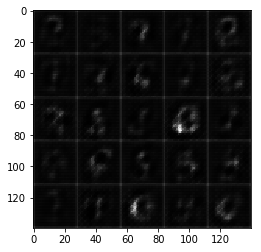

Epoch 1/2... Discriminator Loss: 0.9448... Generator Loss: 0.8727
Epoch 1/2... Discriminator Loss: 0.9930... Generator Loss: 0.8208
Epoch 1/2... Discriminator Loss: 1.1468... Generator Loss: 0.6764
Epoch 1/2... Discriminator Loss: 1.1745... Generator Loss: 1.8989
Epoch 1/2... Discriminator Loss: 1.0384... Generator Loss: 0.8421
Epoch 1/2... Discriminator Loss: 1.4214... Generator Loss: 1.6758
Epoch 1/2... Discriminator Loss: 1.2022... Generator Loss: 0.7157
Epoch 1/2... Discriminator Loss: 1.4008... Generator Loss: 1.7534
Epoch 1/2... Discriminator Loss: 1.1083... Generator Loss: 0.9532
Epoch 1/2... Discriminator Loss: 1.4081... Generator Loss: 0.4077


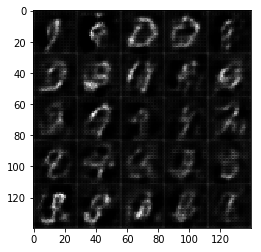

Epoch 1/2... Discriminator Loss: 1.2233... Generator Loss: 0.8577
Epoch 1/2... Discriminator Loss: 1.1377... Generator Loss: 0.6639
Epoch 1/2... Discriminator Loss: 1.1604... Generator Loss: 0.8365
Epoch 1/2... Discriminator Loss: 1.1910... Generator Loss: 0.8102
Epoch 1/2... Discriminator Loss: 1.2442... Generator Loss: 0.6206
Epoch 1/2... Discriminator Loss: 1.2267... Generator Loss: 0.6993
Epoch 1/2... Discriminator Loss: 1.7288... Generator Loss: 2.0666
Epoch 1/2... Discriminator Loss: 1.2144... Generator Loss: 0.7535
Epoch 1/2... Discriminator Loss: 1.0958... Generator Loss: 0.8023
Epoch 1/2... Discriminator Loss: 1.2200... Generator Loss: 0.6150


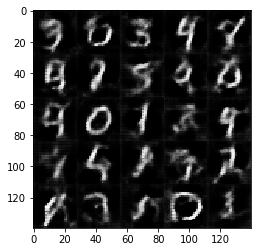

Epoch 1/2... Discriminator Loss: 1.1893... Generator Loss: 1.1381
Epoch 1/2... Discriminator Loss: 1.1017... Generator Loss: 0.7981
Epoch 1/2... Discriminator Loss: 1.4447... Generator Loss: 0.4731
Epoch 1/2... Discriminator Loss: 1.3933... Generator Loss: 1.5428
Epoch 1/2... Discriminator Loss: 1.2522... Generator Loss: 0.6478
Epoch 1/2... Discriminator Loss: 1.1248... Generator Loss: 0.9231
Epoch 1/2... Discriminator Loss: 1.0345... Generator Loss: 0.9997
Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 0.6441
Epoch 1/2... Discriminator Loss: 1.2192... Generator Loss: 0.6140
Epoch 1/2... Discriminator Loss: 1.0630... Generator Loss: 1.3222


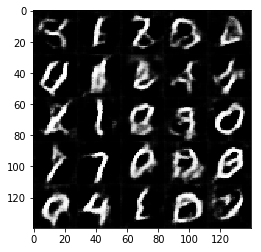

Epoch 1/2... Discriminator Loss: 0.9676... Generator Loss: 1.2931
Epoch 1/2... Discriminator Loss: 1.2742... Generator Loss: 1.7396
Epoch 1/2... Discriminator Loss: 1.0242... Generator Loss: 1.0660
Epoch 1/2... Discriminator Loss: 1.5593... Generator Loss: 0.3378
Epoch 1/2... Discriminator Loss: 1.0234... Generator Loss: 1.1438
Epoch 1/2... Discriminator Loss: 1.1229... Generator Loss: 0.7169
Epoch 1/2... Discriminator Loss: 1.0301... Generator Loss: 1.3290
Epoch 1/2... Discriminator Loss: 1.2943... Generator Loss: 0.4970
Epoch 1/2... Discriminator Loss: 2.2189... Generator Loss: 2.6295
Epoch 1/2... Discriminator Loss: 1.0641... Generator Loss: 0.8425


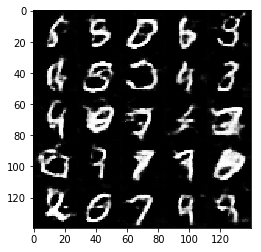

Epoch 1/2... Discriminator Loss: 0.9773... Generator Loss: 0.8154
Epoch 1/2... Discriminator Loss: 1.1614... Generator Loss: 0.5864
Epoch 1/2... Discriminator Loss: 1.0393... Generator Loss: 0.7447
Epoch 1/2... Discriminator Loss: 0.9111... Generator Loss: 0.9537
Epoch 1/2... Discriminator Loss: 2.1044... Generator Loss: 0.1634
Epoch 1/2... Discriminator Loss: 1.1159... Generator Loss: 0.7052
Epoch 1/2... Discriminator Loss: 1.1594... Generator Loss: 1.0423
Epoch 1/2... Discriminator Loss: 1.1247... Generator Loss: 0.6611
Epoch 1/2... Discriminator Loss: 1.1306... Generator Loss: 0.7603
Epoch 1/2... Discriminator Loss: 1.5060... Generator Loss: 0.3356


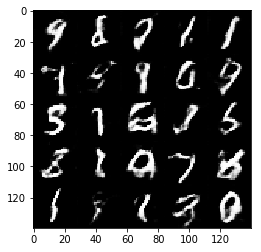

Epoch 1/2... Discriminator Loss: 1.1351... Generator Loss: 0.6793
Epoch 1/2... Discriminator Loss: 1.2403... Generator Loss: 0.5026
Epoch 1/2... Discriminator Loss: 1.2424... Generator Loss: 0.4889
Epoch 1/2... Discriminator Loss: 1.1174... Generator Loss: 0.6859
Epoch 1/2... Discriminator Loss: 1.2565... Generator Loss: 0.6157
Epoch 1/2... Discriminator Loss: 1.1092... Generator Loss: 0.8087
Epoch 1/2... Discriminator Loss: 1.4237... Generator Loss: 0.4093
Epoch 1/2... Discriminator Loss: 1.0079... Generator Loss: 0.7412
Epoch 1/2... Discriminator Loss: 1.1210... Generator Loss: 0.9437
Epoch 1/2... Discriminator Loss: 1.0757... Generator Loss: 1.2965


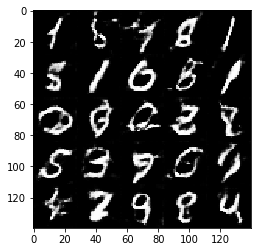

Epoch 1/2... Discriminator Loss: 0.9835... Generator Loss: 1.4824
Epoch 1/2... Discriminator Loss: 1.1893... Generator Loss: 0.8532
Epoch 1/2... Discriminator Loss: 1.4608... Generator Loss: 0.3685
Epoch 1/2... Discriminator Loss: 1.1935... Generator Loss: 0.9072
Epoch 1/2... Discriminator Loss: 1.2859... Generator Loss: 1.1774
Epoch 1/2... Discriminator Loss: 1.1025... Generator Loss: 1.3937
Epoch 1/2... Discriminator Loss: 1.2015... Generator Loss: 0.6357
Epoch 1/2... Discriminator Loss: 0.9071... Generator Loss: 0.8591
Epoch 1/2... Discriminator Loss: 0.9243... Generator Loss: 1.0238
Epoch 1/2... Discriminator Loss: 2.3672... Generator Loss: 0.1950


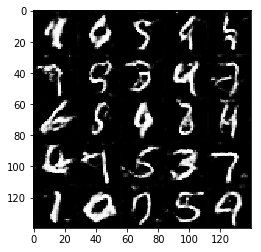

Epoch 1/2... Discriminator Loss: 1.0393... Generator Loss: 0.8139
Epoch 1/2... Discriminator Loss: 1.0584... Generator Loss: 0.8434
Epoch 1/2... Discriminator Loss: 1.1384... Generator Loss: 0.9012
Epoch 1/2... Discriminator Loss: 0.9242... Generator Loss: 0.9172
Epoch 1/2... Discriminator Loss: 1.0255... Generator Loss: 0.9498
Epoch 1/2... Discriminator Loss: 0.9846... Generator Loss: 0.7766
Epoch 1/2... Discriminator Loss: 1.0742... Generator Loss: 1.8190
Epoch 1/2... Discriminator Loss: 1.4637... Generator Loss: 0.4307
Epoch 1/2... Discriminator Loss: 1.5981... Generator Loss: 1.6102
Epoch 1/2... Discriminator Loss: 1.7781... Generator Loss: 0.2719


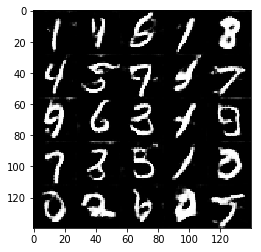

Epoch 1/2... Discriminator Loss: 1.0046... Generator Loss: 1.1224
Epoch 1/2... Discriminator Loss: 0.8283... Generator Loss: 1.5116
Epoch 1/2... Discriminator Loss: 0.9496... Generator Loss: 0.8968
Epoch 2/2... Discriminator Loss: 1.3461... Generator Loss: 0.4453
Epoch 2/2... Discriminator Loss: 1.5479... Generator Loss: 0.4557
Epoch 2/2... Discriminator Loss: 0.9023... Generator Loss: 1.3173
Epoch 2/2... Discriminator Loss: 0.6816... Generator Loss: 1.5238
Epoch 2/2... Discriminator Loss: 0.8843... Generator Loss: 1.3527
Epoch 2/2... Discriminator Loss: 1.2640... Generator Loss: 0.5180
Epoch 2/2... Discriminator Loss: 1.1147... Generator Loss: 1.0035


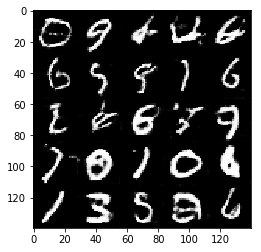

Epoch 2/2... Discriminator Loss: 0.8927... Generator Loss: 1.6344
Epoch 2/2... Discriminator Loss: 1.2924... Generator Loss: 0.5320
Epoch 2/2... Discriminator Loss: 1.2774... Generator Loss: 0.5940
Epoch 2/2... Discriminator Loss: 1.0109... Generator Loss: 1.2238
Epoch 2/2... Discriminator Loss: 1.6364... Generator Loss: 0.3103
Epoch 2/2... Discriminator Loss: 1.2131... Generator Loss: 0.5673
Epoch 2/2... Discriminator Loss: 1.5594... Generator Loss: 0.3439
Epoch 2/2... Discriminator Loss: 0.9915... Generator Loss: 0.7310
Epoch 2/2... Discriminator Loss: 1.2100... Generator Loss: 0.5562
Epoch 2/2... Discriminator Loss: 0.9780... Generator Loss: 0.7649


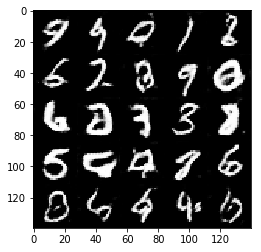

Epoch 2/2... Discriminator Loss: 1.0319... Generator Loss: 0.7448
Epoch 2/2... Discriminator Loss: 0.9905... Generator Loss: 1.2161
Epoch 2/2... Discriminator Loss: 0.9805... Generator Loss: 0.7934
Epoch 2/2... Discriminator Loss: 0.9955... Generator Loss: 1.4303
Epoch 2/2... Discriminator Loss: 0.9514... Generator Loss: 1.4436
Epoch 2/2... Discriminator Loss: 0.8311... Generator Loss: 1.2222
Epoch 2/2... Discriminator Loss: 0.9293... Generator Loss: 0.7606
Epoch 2/2... Discriminator Loss: 0.8394... Generator Loss: 1.2020
Epoch 2/2... Discriminator Loss: 1.5816... Generator Loss: 0.4091
Epoch 2/2... Discriminator Loss: 0.8815... Generator Loss: 1.2261


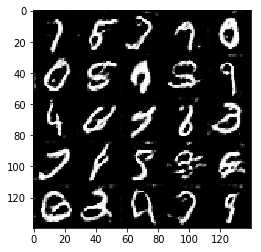

Epoch 2/2... Discriminator Loss: 0.9544... Generator Loss: 0.9528
Epoch 2/2... Discriminator Loss: 1.2204... Generator Loss: 0.4897
Epoch 2/2... Discriminator Loss: 1.5502... Generator Loss: 0.4551
Epoch 2/2... Discriminator Loss: 1.0421... Generator Loss: 0.8661
Epoch 2/2... Discriminator Loss: 0.9805... Generator Loss: 0.7759
Epoch 2/2... Discriminator Loss: 0.9004... Generator Loss: 1.3494
Epoch 2/2... Discriminator Loss: 1.3430... Generator Loss: 0.4527
Epoch 2/2... Discriminator Loss: 1.2365... Generator Loss: 0.5989
Epoch 2/2... Discriminator Loss: 1.0588... Generator Loss: 0.6663
Epoch 2/2... Discriminator Loss: 0.9839... Generator Loss: 0.7172


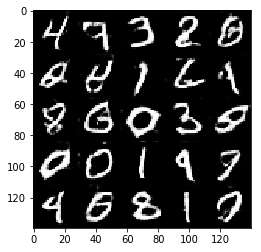

Epoch 2/2... Discriminator Loss: 0.7869... Generator Loss: 0.9851
Epoch 2/2... Discriminator Loss: 0.8349... Generator Loss: 0.8846
Epoch 2/2... Discriminator Loss: 1.0293... Generator Loss: 0.6603
Epoch 2/2... Discriminator Loss: 0.7401... Generator Loss: 1.2691
Epoch 2/2... Discriminator Loss: 1.3964... Generator Loss: 0.4402
Epoch 2/2... Discriminator Loss: 1.1593... Generator Loss: 0.7598
Epoch 2/2... Discriminator Loss: 1.3096... Generator Loss: 0.4869
Epoch 2/2... Discriminator Loss: 0.8110... Generator Loss: 1.3619
Epoch 2/2... Discriminator Loss: 0.8800... Generator Loss: 0.9084
Epoch 2/2... Discriminator Loss: 1.5430... Generator Loss: 0.3613


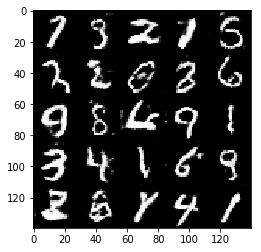

Epoch 2/2... Discriminator Loss: 1.0394... Generator Loss: 1.0378
Epoch 2/2... Discriminator Loss: 0.8937... Generator Loss: 1.5535
Epoch 2/2... Discriminator Loss: 1.1939... Generator Loss: 1.3520
Epoch 2/2... Discriminator Loss: 0.9635... Generator Loss: 0.6813
Epoch 2/2... Discriminator Loss: 1.4494... Generator Loss: 0.3907
Epoch 2/2... Discriminator Loss: 0.9291... Generator Loss: 0.8608
Epoch 2/2... Discriminator Loss: 0.9553... Generator Loss: 0.8230
Epoch 2/2... Discriminator Loss: 0.8106... Generator Loss: 1.3236
Epoch 2/2... Discriminator Loss: 1.4751... Generator Loss: 1.9060
Epoch 2/2... Discriminator Loss: 1.0642... Generator Loss: 0.6036


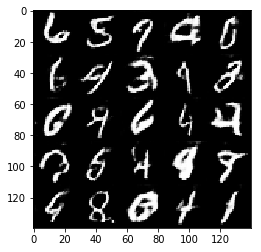

Epoch 2/2... Discriminator Loss: 1.6117... Generator Loss: 0.3152
Epoch 2/2... Discriminator Loss: 1.1443... Generator Loss: 0.7032
Epoch 2/2... Discriminator Loss: 0.8824... Generator Loss: 0.7961
Epoch 2/2... Discriminator Loss: 1.2825... Generator Loss: 2.4963
Epoch 2/2... Discriminator Loss: 0.8850... Generator Loss: 0.9923
Epoch 2/2... Discriminator Loss: 1.1100... Generator Loss: 0.7257
Epoch 2/2... Discriminator Loss: 0.8817... Generator Loss: 1.1609
Epoch 2/2... Discriminator Loss: 0.7631... Generator Loss: 2.0979
Epoch 2/2... Discriminator Loss: 0.9545... Generator Loss: 0.8423
Epoch 2/2... Discriminator Loss: 1.1877... Generator Loss: 1.7691


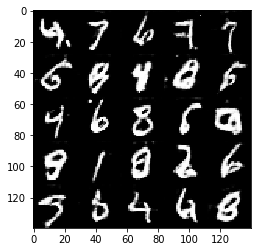

Epoch 2/2... Discriminator Loss: 1.1816... Generator Loss: 0.5750
Epoch 2/2... Discriminator Loss: 1.0236... Generator Loss: 0.7933
Epoch 2/2... Discriminator Loss: 0.7831... Generator Loss: 1.4168
Epoch 2/2... Discriminator Loss: 0.5400... Generator Loss: 2.1676
Epoch 2/2... Discriminator Loss: 0.8062... Generator Loss: 0.8331
Epoch 2/2... Discriminator Loss: 0.9503... Generator Loss: 2.9991
Epoch 2/2... Discriminator Loss: 0.9910... Generator Loss: 0.7109
Epoch 2/2... Discriminator Loss: 0.6539... Generator Loss: 1.2672
Epoch 2/2... Discriminator Loss: 1.8015... Generator Loss: 0.3043
Epoch 2/2... Discriminator Loss: 0.8719... Generator Loss: 0.9578


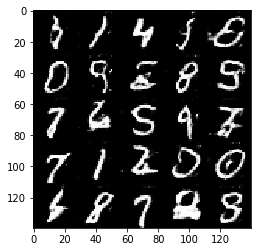

Epoch 2/2... Discriminator Loss: 1.2054... Generator Loss: 0.5190
Epoch 2/2... Discriminator Loss: 1.5113... Generator Loss: 0.5109
Epoch 2/2... Discriminator Loss: 0.8853... Generator Loss: 1.1156
Epoch 2/2... Discriminator Loss: 0.8792... Generator Loss: 1.0579
Epoch 2/2... Discriminator Loss: 0.8711... Generator Loss: 1.2682
Epoch 2/2... Discriminator Loss: 0.9569... Generator Loss: 0.7233
Epoch 2/2... Discriminator Loss: 0.8671... Generator Loss: 0.8890
Epoch 2/2... Discriminator Loss: 0.6887... Generator Loss: 1.1193
Epoch 2/2... Discriminator Loss: 1.8784... Generator Loss: 0.2949
Epoch 2/2... Discriminator Loss: 1.1655... Generator Loss: 0.6391


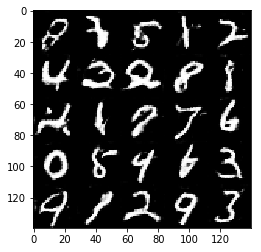

Epoch 2/2... Discriminator Loss: 0.5726... Generator Loss: 1.8716
Epoch 2/2... Discriminator Loss: 1.5382... Generator Loss: 0.4003
Epoch 2/2... Discriminator Loss: 1.3433... Generator Loss: 0.5656
Epoch 2/2... Discriminator Loss: 0.9669... Generator Loss: 0.7535
Epoch 2/2... Discriminator Loss: 0.6067... Generator Loss: 1.2299
Epoch 2/2... Discriminator Loss: 1.8492... Generator Loss: 0.2747
Epoch 2/2... Discriminator Loss: 0.9377... Generator Loss: 1.1137


In [ ]:
batch_size = 2**6
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2393... Generator Loss: 29.5751
Epoch 1/1... Discriminator Loss: 0.0120... Generator Loss: 29.6863
Epoch 1/1... Discriminator Loss: 0.0297... Generator Loss: 23.7358
Epoch 1/1... Discriminator Loss: 0.1200... Generator Loss: 2.9642
Epoch 1/1... Discriminator Loss: 5.2406... Generator Loss: 0.0259
Epoch 1/1... Discriminator Loss: 0.3189... Generator Loss: 2.4978
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 3.6792
Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 1.6592... Generator Loss: 0.3270
Epoch 1/1... Discriminator Loss: 0.3124... Generator Loss: 2.3572


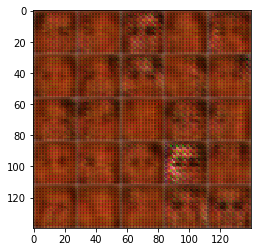

Epoch 1/1... Discriminator Loss: 0.6548... Generator Loss: 1.6562
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 2.4155
Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 1.5796
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.9284
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 0.3758... Generator Loss: 1.7124
Epoch 1/1... Discriminator Loss: 1.8181... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 1.3428


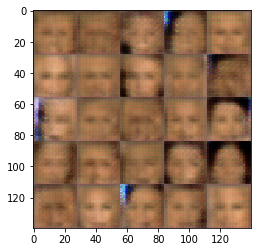

Epoch 1/1... Discriminator Loss: 0.8640... Generator Loss: 1.0463
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 1.0069
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.5573
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 2.3278... Generator Loss: 4.0994
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 1.2506
Epoch 1/1... Discriminator Loss: 1.6256... Generator Loss: 0.2801
Epoch 1/1... Discriminator Loss: 1.6304... Generator Loss: 1.8373
Epoch 1/1... Discriminator Loss: 2.3422... Generator Loss: 2.5093


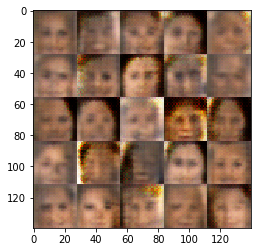

Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.4885
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.5426
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 1.2917
Epoch 1/1... Discriminator Loss: 1.6560... Generator Loss: 0.4077
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.5520
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.5647... Generator Loss: 0.4007


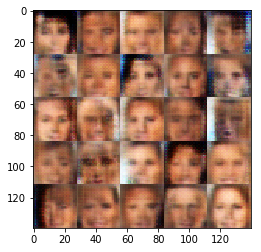

Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.5281
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 1.1894
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.5165
Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 1.0271
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.7859


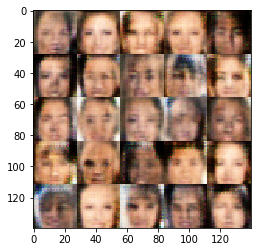

Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.0904... Generator Loss: 1.0688
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.4993
Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 1.0549
Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 1.4871
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.6753


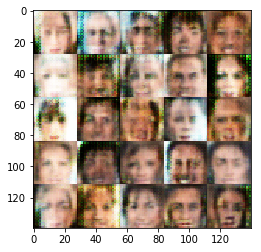

Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 1.5569... Generator Loss: 0.3493
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.4236
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.7285


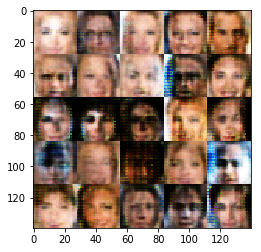

Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.4973
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.3656
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 1.0974


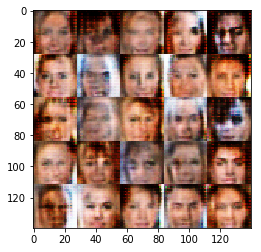

Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.5137
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 1.2460
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.8248... Generator Loss: 0.2711
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.8622


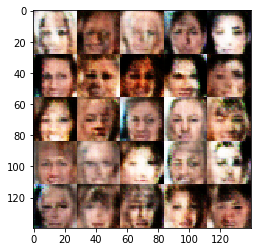

Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 0.7686


In [ ]:
batch_size = 2**6
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.